In [20]:
# Major version: the feature setup
# Minor version: model hypertunning
VERSION = 'v1.1'
major_VERSION = VERSION.split('.')[0]+'.0'

# Model Details
## Features:
- One hot encoded **day of week** and **month** (not year)
- Weather feature (OHE):
    - Icons (cloudy, partial cloudy, ...)
    - Precipitates Type (None, Snow, Sleet, Rain)
- Station info:
    - community area (OHE)
    - capacity
    - long, lat
    
## Target
- Log scale/normal scale
    
# Work Flow
## Training Preprocessing
- Merge station community area (Join tables)
- Drop id after merging
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Pipeline
- OHE on date time (Remember column indices)
- Scaling for `year, lon_ave, lat_ave, dp_max, temp_high, temp_low` (`MinMaxScaler`)
- Regressor()

## Test Preprocessing
- Start with Pandas template (station_id, lon_ave, lat_ave, dp_max, OHE community area)
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Post prediction
- Rescale if trained on log
- Hard cap negative (activation function)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

## Load data

In [17]:
INFO_verbose = False

In [18]:
%%time
st_template = pd.read_pickle('../data/model_v1.0_template.pk')

CPU times: user 3.22 ms, sys: 277 µs, total: 3.49 ms
Wall time: 4.51 ms


In [19]:
if INFO_verbose:
    st_template.info()

In [20]:
%%time
## load preprocessed data

if os.path.exists('../data/divvy_data_model_'+major_VERSION+'.pk'):
    print("Loading from previous pickle file.")
    data = pd.read_pickle('../data/divvy_data_model_'+major_VERSION+'.pk')
else:
    print("Create data set for this model... ")
    data_lst = []

    for year in [2013, 2014, 2015, 2016, 2017, 2018]:
        dt_tmp = pd.read_feather('../data/Final_Divvy_data_'+str(year)+'.feather')
        data_lst.append(dt_tmp)

    data = pd.concat(data_lst, ignore_index=True)


    data.to_pickle('../data/divvy_data_model_'+major_VERSION+'.pk')
    print("Data saved to pickle file")

Loading from previous pickle file.
CPU times: user 360 ms, sys: 203 ms, total: 563 ms
Wall time: 2.81 s


In [21]:
if INFO_verbose:
    data.info()

## Get target value

In [22]:
target_in = data.total_in
target_out = data.total_out

In [23]:
target_in_log = np.log(target_in+1)

## Prepare features

In [24]:
# Prescreening for useful features
feats = pd.merge(data[['station_id', 'month', 'dayofweek', 'year',
                       'icon_clear-day', 'icon_cloudy', 'icon_partly-cloudy-day', 
                       'icon_rain', 'icon_sleet', 'icon_snow',
                       'precipType_None', 'precipType_rain',
                       'precipType_sleet', 'precipType_snow',
                       'temperatureHigh', 'temperatureLow' 
                         ]], st_template, 
                    left_on='station_id', right_on='id').drop(['station_id', 'id'], axis=1)

## Reordering dataframe

In [25]:
# Reordering
cols = []
cols.extend(feats.columns[15:])
cols.extend(feats.columns[2:15])
cols.extend(feats.columns[:2])

In [26]:
feats_ro = feats[cols]

In [27]:
if INFO_verbose:
    feats_ro.info()

In [28]:
feats_ro = feats_ro.fillna(0)

## Get/Check indices for numerical columns 

In [29]:
num_col_in = [0, 1, 2, 50, 61, 62]

In [30]:
feats_ro.iloc[:, num_col_in].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 6 columns):
lon_ave            947515 non-null float64
lat_ave            947515 non-null float64
dp_max             947515 non-null float64
year               947515 non-null float64
temperatureHigh    947515 non-null float64
temperatureLow     947515 non-null float64
dtypes: float64(6)
memory usage: 50.6 MB


## One hot encoding date

In [31]:
feats_fnl = pd.get_dummies(feats_ro, columns=['month', 'dayofweek'])

## Save model details into txt 

In [32]:
import io

buffer = io.StringIO()
feats_fnl.info(buf=buffer)
s = buffer.getvalue()

with open("../model_features_details/features_"+major_VERSION+'.txt', "w", encoding="utf-8") as f: 
    f.write(s)

## Convert to numpy matrix 

In [33]:
features_ = feats_fnl.to_numpy()

In [34]:
features_.shape

(947515, 82)

## Building pipelines

In [80]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

In [36]:
sklearn.__version__

'0.21.2'

In [37]:
%%time
model = Pipeline([
    ('mms', MinMaxScaler(feature_range=(0, 1), copy=False)),
    ('rf', RandomForestRegressor(n_estimators=10, min_samples_split=5))
])

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_out, 
    test_size=0.2, 
    random_state=42)

CPU times: user 894 ms, sys: 826 ms, total: 1.72 s
Wall time: 1.72 s


In [38]:
%%time
model.fit(X_train, y_train)

CPU times: user 2min 7s, sys: 78.2 ms, total: 2min 7s
Wall time: 2min 7s


Pipeline(memory=None,
         steps=[('mms', MinMaxScaler(copy=False, feature_range=(0, 1))),
                ('rf',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [39]:
# Save model, features and targets
Model_name = 'random_forest_'

with open('../model_data/'+Model_name+'model_'+VERSION+'.pk', 'wb') as p:
    pickle.dump(model, p)

with open('../model_data/'+Model_name+'testfeature_'+VERSION+'.pk', 'wb') as ptf:
    pickle.dump(X_test, ptf)

with open('../model_data/'+Model_name+'testarget_'+VERSION+'.pk', 'wb') as ptg:
    pickle.dump(y_test, ptg)

In [40]:
model.score(X_test, y_test)

0.6739930473027973

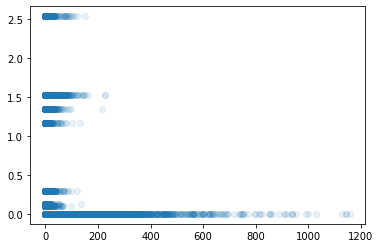

In [41]:
# First check
y_pred = model.predict(X_test)
plt.plot(y_test, y_pred, 'o', alpha=0.1)

## Grid Search 

In [29]:
%%time
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_out, 
    test_size=0.2, 
    random_state=42)
print("Train/Test splitted...")

model_gs = GridSearchCV(
    model,
    {'rf__n_estimators': [20, 50], 'rf__max_depth':[5, 10, 20]},
    cv=5,
    n_jobs=4
)


model_gs.fit(X_train, y_train)
print("Best params: ", model_gs.best_params_)

Best params:  {'rf__max_depth': 5, 'rf__n_estimators': 20}
CPU times: user 1min 37s, sys: 663 ms, total: 1min 38s
Wall time: 2min 23s


In [30]:
y_pred = model_gs.predict(X_test)
plt.plot(y_test, y_pred, 'o', alpha=0.1)

In [ ]:
# Save model, features and targets
Model_name = 'random_forest_'

with open('../model_data/'+Model_name+'model_'+VERSION+'.pk', 'wb') as p:
    pickle.dump(model_gs, p)

with open('../model_data/'+Model_name+'testfeature_'+VERSION+'.pk', 'wb') as ptf:
    pickle.dump(X_test, ptf)

with open('../model_data/'+Model_name+'testraget_'+VERSION+'.pk', 'wb') as ptg:
    pickle.dump(y_test, ptg)

## Reload model

In [75]:
%%time
# Load previous data
Model_name = 'random_forest_'
with open('../model_data/'+Model_name+'model_'+VERSION+'.pk', 'rb') as pp:
    loaded_model = pickle.load(pp)

with open('../model_data/'+Model_name+'testfeature_'+VERSION+'.pk', 'rb') as ptfl:
    loaded_test_feature = pickle.load(ptfl)

with open('../model_data/'+Model_name+'testarget_'+VERSION+'.pk', 'rb') as ptgl:
    loaded_test_target = pickle.load(ptgl)

CPU times: user 126 ms, sys: 237 ms, total: 363 ms
Wall time: 362 ms


In [89]:
tst_mms = MinMaxScaler(copy=False)

In [90]:
tst_mms.fit_transform(loaded_test_feature)

array([[0.54976375, 0.5611146 , 0.16666667, ..., 0.        , 1.        ,
        0.        ],
       [0.07817068, 0.49213304, 0.08333333, ..., 0.        , 0.        ,
        0.        ],
       [0.38499342, 0.52748029, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.46074076, 0.66328327, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.80087566, 0.16706479, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.37693929, 0.56329827, 0.16666667, ..., 0.        , 0.        ,
        0.        ]])

In [93]:
tst_mms.transform(loaded_test_feature)

array([[-1.17616822e+02,  6.21272379e+01,  4.72101899e+19, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.17616822e+02,  6.21272378e+01,  3.47445779e+19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.17616822e+02,  6.21272378e+01,  4.72101899e+19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.17616822e+02,  6.21272380e+01,  4.72101899e+19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.17616822e+02,  6.21272372e+01,  9.70726376e+19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.17616822e+02,  6.21272379e+01,  4.72101899e+19, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [85]:
tst_mms.transform(loaded_test_feature)

array([[0.54976375, 0.5611146 , 0.16666667, ..., 0.        , 1.        ,
        0.        ],
       [0.07817068, 0.49213304, 0.08333333, ..., 0.        , 0.        ,
        0.        ],
       [0.38499342, 0.52748029, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.46074076, 0.66328327, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.80087566, 0.16706479, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.37693929, 0.56329827, 0.16666667, ..., 0.        , 0.        ,
        0.        ]])

In [86]:
loaded_model.score(loaded_test_feature, loaded_test_target)

-0.27058366821123614

In [77]:
loaded_model.steps[0][1].transform(loaded_test_feature)

array([[ 3.48553385e+02, -1.25455600e+02, -1.42361111e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.46692939e+02, -1.25665776e+02, -1.44097222e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.47903362e+02, -1.25558078e+02, -1.42361111e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.48202188e+02, -1.25144307e+02, -1.42361111e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.49544028e+02, -1.26656210e+02, -1.35416667e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.47871589e+02, -1.25448946e+02, -1.42361111e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [78]:
loaded_model.score(loaded_test_feature, loaded_test_target)

-0.27058366821123614

In [79]:
loaded_model.steps[0][1].transform(loaded_test_feature)

array([[ 7.13749536e+03, -1.67925846e+03, -1.48933316e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 7.10854081e+03, -1.68120959e+03, -1.48934070e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.12737890e+03, -1.68020980e+03, -1.48933316e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.13202959e+03, -1.67636865e+03, -1.48933316e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.15291296e+03, -1.69040407e+03, -1.48930302e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.12688440e+03, -1.67919670e+03, -1.48933316e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [61]:
pred = loaded_model.predict(loaded_test_feature)

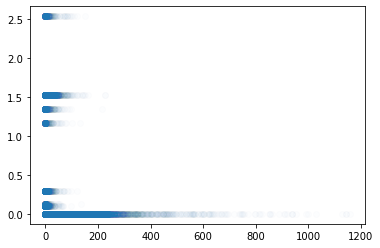

In [62]:
plt.plot(loaded_test_target, pred, 'o', alpha=0.01)
# plt.xlim(0, 200)
# plt.ylim(0, 200)

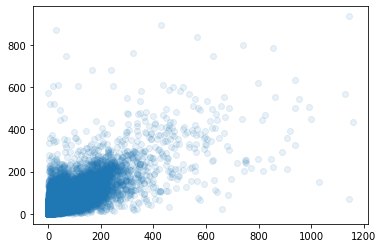

In [51]:
plt.plot(loaded_test_target, pred, 'o', alpha=0.1)